## Homework 2: Scrape, Clean and Normalize Gutenberg's bookshelf
### Author: Shravan Kuchkula

## Introduction
This notebook illustrates four key NLP tasks:
1. Scrape a static website using BeautifulSoup
2. Clean the text using regular expressions and string processing
3. Normalize the text
4. Perform Text analysis

### Problem Statement:
[Gutenberg's Children Bookshelf](http://www.gutenberg.org/wiki/Children%27s_Instructional_Books_(Bookshelf)) consists of 104 texts organized into several categories. Each of these texts is available in several formats like: html, epub, kindle, plain text utf-8 etc. The links to each of these formats can be found by clicking on the main link. For example, link to the book: [The Book of Nature Myths](http://www.gutenberg.org/ebooks/22420) lists the formats available. Our goal is to programatically parse the html to obtain the **plain text utf-8** version of the book, which in this case looks like this: [Plain Text UTF-8](http://www.gutenberg.org/cache/epub/22420/pg22420.txt). Using normalized vocabulary size and lexical diversity as a measure, **can we measure the text difficulty of each of these texts ?**

### Approach to calculating text difficulty:
The approach used can be broken down into three parts:
- Part 1: Scrape the gutenberg website.
- Part 2: Clean and pre-process the text.
- Part 3: Normalize the text and build text difficulty function.

Three modules were developed which consists of several utility functions (see **Appendix** for code):
- **scrapeGutenberg**: Contains a collection of functions which are used to *scrape* the data from gutenberg's website.
- **gutenbergPreprocessing**: Contains a collection of functions which are used to *clean and pre-process* the gutenberg texts.
- **gutenbergTextNormalization**: Contains a collection of functions which are used to *normalize and analyze* the texts.

### Part 1: Scrape the gutenberg website
`requests` package is used to make the initial request to obtain the HTML. Next, `BeautifulSoup` package is used to parse the HTML and extract the text version of the e-book. 

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from scrapeGutenberg import *
from gutenbergPreprocessing import *
from gutenbergTextNormalization import *

In [2]:
# bookshelf url
bookshelf = 'http://www.gutenberg.org/wiki/Children%27s_Instructional_Books_(Bookshelf)'

# from the bookshelf get all the book_urls, titles, 
# authors and soup(for getting categories)
book_urls, titles, authors, soup = getBookURLsFromBookShelf(bookshelf)

# construct a books dataframe
books = pd.DataFrame({'url': book_urls, 'title': titles, 'author(s)': authors})

# get books df with categories
books = getCategories(soup, books)

# with categories
display(books.shape)
books.head()

(104, 5)

,url,title,author(s),title_id,category
0,http://www.gutenberg.org/ebooks/7841.txt.utf-8,"A Primary Reader: Old-time Stories, Fairy Tale...",Children,7841,Misc.
1,http://www.gutenberg.org/ebooks/5742.txt.utf-8,The Bird-Woman of the Lewis and Clark Expedition,Katherine Chandler,5742,Misc.
2,http://www.gutenberg.org/ebooks/13539.txt.utf-8,"Dr. Scudder's Tales for Little Readers, About ...",John Scudder,13539,Misc.
3,http://www.gutenberg.org/ebooks/7425.txt.utf-8,The Louisa Alcott Reader: a Supplementary Read...,Unknown,7425,Misc.
4,http://www.gutenberg.org/ebooks/16046.txt.utf-8,Boy Blue and His Friends,Mary Frances Blaisdell and Etta Blaisdell McD...,16046,Misc.


`getBookURLsFromBookShelf()` function takes the bookshelf URL and returns a list of: **book_urls, titles, authors, and soup**. In order the extract the categories, the soup objects are parsed to extract the categories. Finally, all the information collected is neatly summarized in a **books dataframe**. The output also shows that `104 books` were scrapped, which is the expected length of the number of books found in the bookshelf.

### Part 2: Clean and pre-process the texts
Gutenberg's text contains a lot of headers and footers which are not relevant to the content of the book. Upon careful observation, it was found that each of the texts contains some common start and end patterns. While this is arbitrary, we can rely on **regular expressions** to come up with a list of all possible starts and ends of the texts. 

The `possible_starts` list contains a list of regular expressions (raw strings) which are used to find the beginning of the text. As the occurrence of these patterns can be anywhere in the text, we obtain the indexes of each of the matches and then use the lowest index in the list as our starting point. This logic is captured in the `moveToStartOfTheBook()` function of `gutenbergPreprocessing` module.

In [3]:
# get the book urls from the dataframe
book_urls = list(books.url.values)

# keep only text between *START* and *END* 
book_texts = getTextFromURLByRemovingHeaders(book_urls)

# list of regular expressions of possible starts
possible_starts = [r'INTRODUCTION', r'\[?ILLUSTRATION', r'CONTENTS', r'IMPRUDENCE', r'TABLE DES MATI',
                  r'THE ALPHABET', r'SELECTIONS IN PROSE AND POETRY', r'THE PLAN BOOK SERIES', 
                  r'STORIES FROM LIVY', r'CHAPTER ONE', r'POEMS TEACHERS ASK FOR', r'OP WEG NAAR SCHOOL.',
                  r'HOW TO USE THE BOOK']

# iterate over the list of possible starts and find the best starting point
book_texts = [moveToStartOfTheBook(possible_starts, book) for book in book_texts]

Now that we have acquired a good starting and ending of the text, the next step is to clean and pre-process the text in prepration for normalization. The following tasks are applied to each of the `book_texts` items:
- **tokenize_text()**: `nltk.RegexpTokenizer` was used to split the text using *r'\s+'*
- **remove_characters_after_tokenization()**: `string.punctuation` is a list of commonly found punctuations, which are removed.
- **convert_to_lowercase()**: all tokens are lowercased and non-alpha characters are removed.
- **remove_stopwords()**: Stop words found in nltk.stopwords('english') are removed. 
- **apply_stemming_and_lemmatize()**: `LancasterStemmer` and `WordNetLemmatizer` are used to normalize the text.

All of these are applied in sequence as part of the `cleanTextBooks()` function.

In [5]:
clean_books = cleanTextBooks(book_texts)

### Part 3: Normalize the text and build the text difficulty function

### Homework Question 1: In Python, create a method for scoring the vocabulary size of a text, and normalize the score from 0 to 1. It does not matter what method you use for normalization as long as you explain it in a short paragraph. (Various methods will be discussed in the live session.)

`normalizedVocabularyScore()` function is used to get a normalized vocabulary score for each of the texts. The method used to normalize is as follows:
- Calculate the vocabulary size. **v_size**
- Get the max vocabulary size of all the texts. **max_v_size**
- Calculate the raw score as: **v_size/max_v_size**
- Calculate the sqrt of raw score and store it as: **v_sqrt_score**
- Normalize the scores between 0 and 1 using ascending rank score, which is calculated as **pd.Series(v_size).rank()/len(v_size)** and store it as: **v_rank_score**
- Finally calculate the **v_final_score = (v_sqrt_score + v_rank_score)/2**

In [6]:
normalizedVocab = normalizedVocabularyScore(clean_books)
summary = pd.concat([books, normalizedVocab], axis=1)

In [8]:
cols = ['title', 'v_size', 'v_raw_score', 'v_sqrt_score', 'v_rank_score', 'v_final_score', 'category']
display(summary[cols].head())
display(summary[cols].tail())

,title,v_size,v_raw_score,v_sqrt_score,v_rank_score,v_final_score,category
0,"A Primary Reader: Old-time Stories, Fairy Tale...",628,0.061472,0.247936,0.076923,0.162429,Misc.
1,The Bird-Woman of the Lewis and Clark Expedition,832,0.081441,0.285378,0.115385,0.200382,Misc.
2,"Dr. Scudder's Tales for Little Readers, About ...",2694,0.263704,0.513521,0.432692,0.473107,Misc.
3,The Louisa Alcott Reader: a Supplementary Read...,2701,0.264389,0.514188,0.442308,0.478248,Misc.
4,Boy Blue and His Friends,884,0.086531,0.294161,0.125000,0.209581,Misc.


,title,v_size,v_raw_score,v_sqrt_score,v_rank_score,v_final_score,category
99,Orthography,3491,0.341719,0.584567,0.576923,0.580745,Uncategorized
100,Stories From Livy,2433,0.238156,0.488012,0.336538,0.412275,Uncategorized
101,A Little Book for A Little Cook,340,0.033281,0.182431,0.038462,0.110446,Uncategorized
102,Ontario Teachers' Manuals: Household Management,2610,0.255482,0.505452,0.394231,0.449841,Uncategorized
103,Ontario Teachers' Manuals: Household Science i...,2621,0.256558,0.506516,0.403846,0.455181,Uncategorized


#### Plot showing the relation between v_final_score and categories

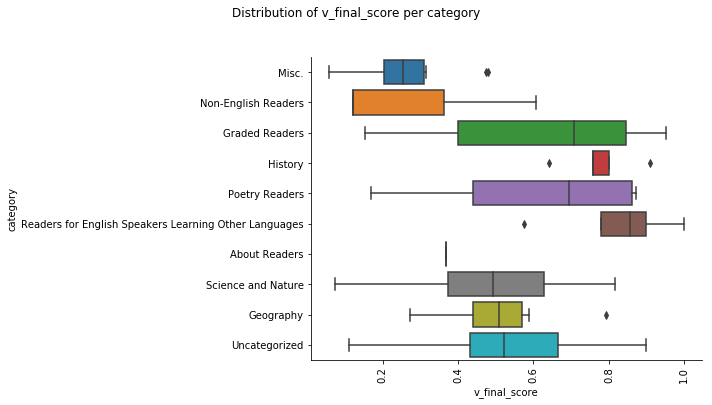

In [9]:
g = sns.catplot(y="category", x="v_final_score", data=summary, 
                kind="box", orient='h', aspect=2)
g.fig.suptitle("Distribution of v_final_score per category", y=1.1)
plt.xticks(rotation=90)
plt.show()

Some categories like *Readers for English Speakers learning other languages*, *Graded Readers*, *Poetry Readers*, and *History* seem to be having higher Vocabulary scores when compared to texts from other categories.

#### Plot showing the relation between v_final_score and lexical diversity

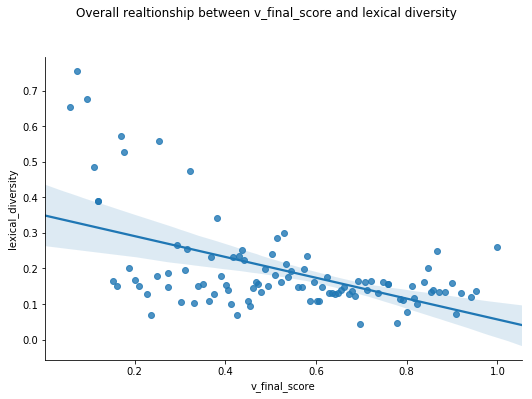

In [10]:
# relation b/w lexical diversity and v_final_score
lexical_diversity = [len(set(book))/len(book) for book in clean_books]
summary['lexical_diversity'] = lexical_diversity

g = sns.lmplot(x='v_final_score', y='lexical_diversity', data=summary, aspect=1.5)
g.fig.suptitle("Overall realtionship between v_final_score and lexical diversity", y=1.1)
plt.show()

It can be readily observed that there appears to be a negative correlation between `v_final_score` and `lexical_diversity` score. While there are a few outliers, the trend can be better observed when broken down by category.

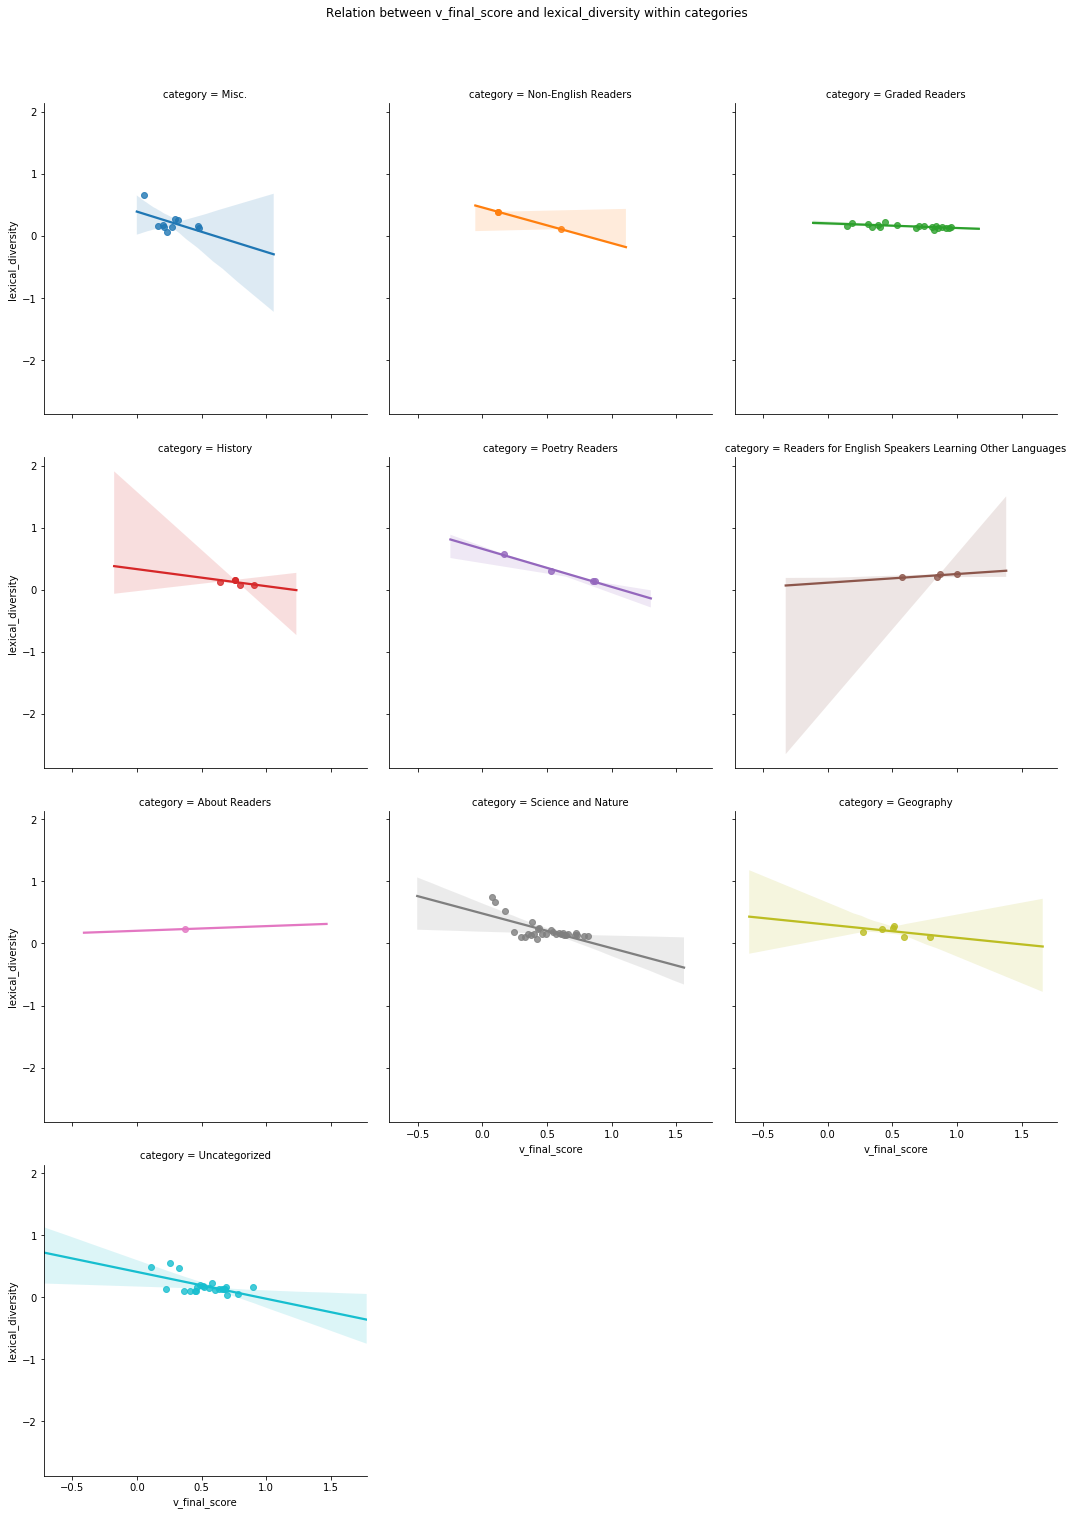

In [11]:
g = sns.lmplot(x='v_final_score', y='lexical_diversity', data=summary, col='category', hue='category', col_wrap=3)
g.fig.suptitle("Relation between v_final_score and lexical_diversity within categories", y=1.05)
plt.show()

With the exception of *Readers for English Speakers Learning Other Languages*, all the other categories exhibit the general negative trend observed in the overall v_final_score.  

###  2.	After consulting section 3.2 in chapter 1 of Bird-Klein, create a method for scoring the long-word vocabulary size of a text, and likewise normalize (and explain) the scoring as in step 1 above.

`normalizedLongWordVocabularyScore()` function first filters the long words(minchar > 10) in texts and then applies the same normalization process:
- Calculate the long word vocabulary size. **lw_v_size**
- Get the max vocabulary size of all the texts. **max_v_size**
- Calculate the raw score as: **lw_v_size/max_v_size**
- Calculate the sqrt of raw score and store it as: **v_sqrt_score**
- Normalize the scores between 0 and 1 using ascending rank score, which is calculated as **pd.Series(v_size).rank()/len(v_size)** and store it as: **v_rank_score**
- Finally calculate the **lw_v_final_score = (v_sqrt_score + v_rank_score)/2**

A summary of the *lw_v_size* and *lw_v_final_score* is shown below:

In [13]:
normalizedLWVocab = normalizedLongWordVocabularyScore(clean_books)
summary = pd.concat([summary, normalizedLWVocab], axis=1)

cols = ['title', 'lw_v_size', 'lw_v_final_score', 'category']
summary[cols].head()

,title,lw_v_size,lw_v_final_score,category
0,"A Primary Reader: Old-time Stories, Fairy Tale...",1,0.037476,Misc.
1,The Bird-Woman of the Lewis and Clark Expedition,5,0.096086,Misc.
2,"Dr. Scudder's Tales for Little Readers, About ...",46,0.325668,Misc.
3,The Louisa Alcott Reader: a Supplementary Read...,44,0.315737,Misc.
4,Boy Blue and His Friends,5,0.096086,Misc.


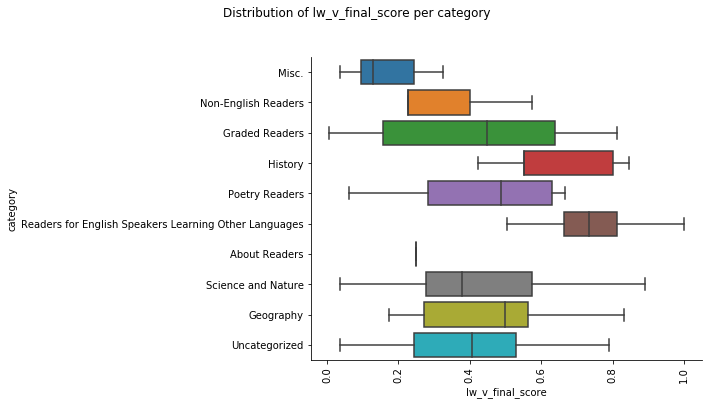

In [14]:
g = sns.catplot(y="category", x="lw_v_final_score", data=summary, 
                kind="box", orient='h', aspect=2)
g.fig.suptitle("Distribution of lw_v_final_score per category", y=1.1)
plt.xticks(rotation=90)
plt.show()

The boxplot shows a similar trend for *lw_v_final_score* values for each of the categories.

###  3.	Now create a “text difficulty score” by combining the lexical diversity score from homework 1, and your normalized score of vocabulary size and long-word vocabulary size, in equal weighting. Explain what you see when this score is applied to same graded texts you used in homework 1.

`textDifficultyScore()` is a function which takes a list of books and calculates the text difficult using the below formula:
> Text Difficulty = ((Normalized Vocabulary Size) + (Normalized Long Word Vocabulary Size) + (Lexical Diversity))/3

A summary of each book and it's `text_difficulty` score is displayed below:

In [15]:
text_difficulty = textDifficultyScore(clean_books)
summary = pd.concat([summary, text_difficulty], axis=1)

cols = ['title', 'text_difficulty', 'lexical_diversity', 'lw_v_final_score', 'v_final_score', 'category']
summary[cols]

,title,text_difficulty,lexical_diversity,lw_v_final_score,v_final_score,category
0,"A Primary Reader: Old-time Stories, Fairy Tale...",0.117235,0.151801,0.037476,0.162429,Misc.
1,The Bird-Woman of the Lewis and Clark Expedition,0.154646,0.167472,0.096086,0.200382,Misc.
2,"Dr. Scudder's Tales for Little Readers, About ...",0.318813,0.157664,0.325668,0.473107,Misc.
3,The Louisa Alcott Reader: a Supplementary Read...,0.309153,0.133475,0.315737,0.478248,Misc.
4,Boy Blue and His Friends,0.151858,0.149907,0.096086,0.209581,Misc.
5,The Book of Nature Myths,0.147111,0.070192,0.135032,0.236110,Misc.
6,The Flag of My Country = Shikéyah Bidah Na'at'...,0.245298,0.389189,0.226402,0.120302,Non-English Readers
7,Chambers's Elementary Science Readers,0.182339,0.148904,0.125004,0.273109,Misc.
8,The Little Lame Prince,0.280385,0.255332,0.269849,0.315976,Misc.
9,Harry's Ladder to Learning,0.240807,0.266622,0.162018,0.293781,Misc.


#### Plot showing the text difficulty of each category

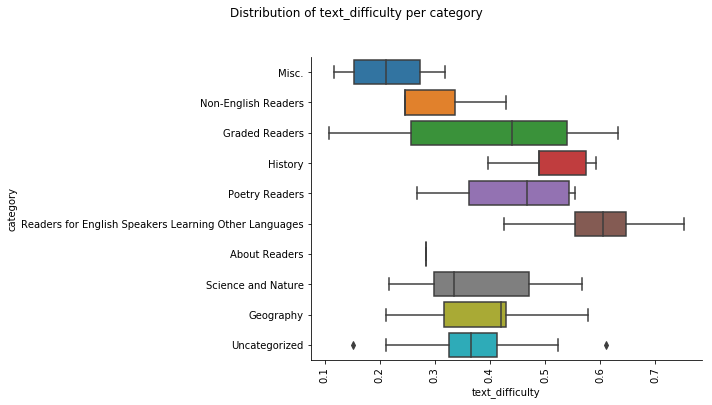

In [16]:
g = sns.catplot(y="category", x="text_difficulty", data=summary, 
                kind="box", orient='h', aspect=2)
g.fig.suptitle("Distribution of text_difficulty per category", y=1.1)
plt.xticks(rotation=90)
plt.show()

The power of text mining is revealed in this plot. We scraped hundereds' of texts (without knowing anything about them) and extracted an insight that some categories do tend to have difficult texts. In this case, the category *Readers for English Speakers Learning Other languages* clearly shows that it has greater text difficulty than the rest of the categories.

#### Can lexical diversity *alone* be used to guage a texts' difficulty ?
The plot below shows that there is a slight negative trend, that is, texts that are more difficult seem to have less lexical diversity. The trend however is **not** very significant to strongly conclude that lexical diversity alone can be used.

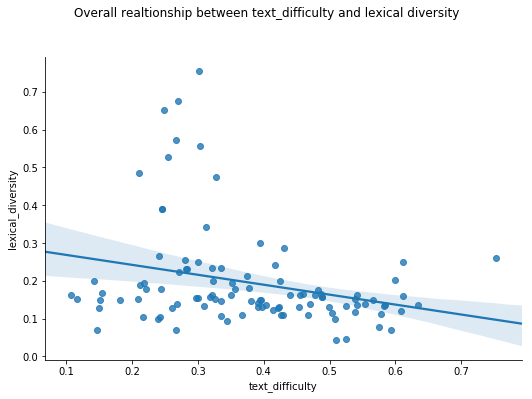

In [17]:
g = sns.lmplot(x='text_difficulty', y='lexical_diversity', data=summary, aspect=1.5)
g.fig.suptitle("Overall realtionship between text_difficulty and lexical diversity", y=1.1)
plt.show()

#### Can vocabulary size *alone* be used to guage a texts' difficulty ?
While the trend clearly shows that greater the vocabulary size, greater the texts' difficulty score, it is definitely a strong feature in determining the text difficulty.

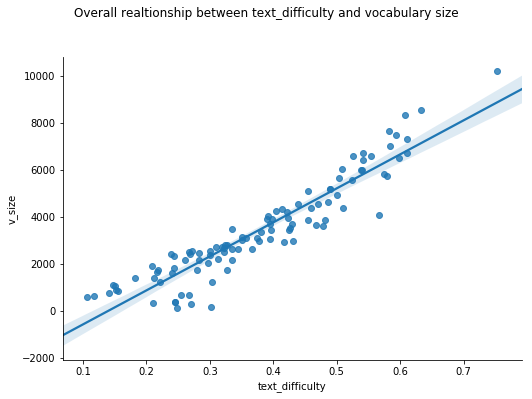

In [18]:
g = sns.lmplot(x='text_difficulty', y='v_size', data=summary, aspect=1.5)
g.fig.suptitle("Overall realtionship between text_difficulty and vocabulary size", y=1.1)
plt.show()

#### Can lexical diversity and vocabulary size be used together to guage text difficulty ?
Yes, as both the above plots indicate that both lexical diversity score and vocabulary size do tend to correlate with text difficulty. As text difficulty itself, has been constructed by combining vocabulary size and lexical diversity, we can say that both of them taken together give a **better estimate** of the text difficulty than when taken alone.

### From homework 1: What do we observe when we apply text difficulty score to the three texts from Homework 1 ?

In [19]:
# grade-level: high school
url1 = "http://www.gutenberg.org/files/22795/22795-0.txt"

# grade-level: third
url2 = "http://www.gutenberg.org/cache/epub/14766/pg14766.txt"

# grade-level: sixth
url3 = "http://www.gutenberg.org/cache/epub/16751/pg16751.txt"

urls = [url1, url2, url3]

In [22]:
book_urls = urls
book_texts= getTextFromURLByRemovingHeaders(book_urls)
clean_books = cleanTextBooks(book_texts)
hw1_text_difficulty = textDifficultyScore(clean_books)
lexical_diversity_scores = [len(set(book))/len(book) for book in clean_books]

In [23]:
hw1_text_difficulty['lexical_diversity_scores'] = lexical_diversity_scores
hw1_text_difficulty

,text_difficulty,lexical_diversity_scores
0,0.546840,0.150651
1,0.298212,0.179144
2,0.706361,0.119084


As we have discovered in the earlier section that text_difficulty is inversely related to lexical_diversity score, the same trend is observed when we apply the text difficulty function to the 3 texts from homework 1.  The book with highest text_difficulty score has the lowest lexical diversity score.

## Text Mining / Text Analytics packages
The Python ecosystem is very diverse and supports a wide variety of libraries, frameworks, and modules in many domains. Because we will be analyzing textual data and performing various operations on it, you need to know about dedicated frameworks and libraries for text analytics that you can just install and start using—just like any other built-in module in the Python standard library. These frameworks have been built over a long period of time and contain various methods, capabilities, and features for operating on text, getting insights, and making the data ready for further analysis, such as applying machine learning algorithms on pre- processed textual data.

Leveraging these frameworks saves a lot of effort and time that would have been otherwise spent on writing boilerplate code to handle, process, and manipulate text data. Thus, the frameworks enable developers and researchers to focus more on solving actual problems and the necessary logic and algorithms needed for doing so. We have already seen some of the NLTK library in the first chapter. The following list of libraries and frameworks are some of the most popular text analytics frameworks:
* **NLTK**: The Natural Language Toolkit is a complete platform that contains more than 50 corpora and lexical resources. It also provides the necessary tools, interfaces, and methods to process and analyze text data.
* **pattern**: The pattern project started out as a research project at the Computational Linguistics & Psycholinguistics research center at the University of Antwerp. It provides tools and interfaces for web mining, information retrieval, NLP, machine learning, and network analysis. The pattern.en module contains most of the utilities for text analytics.
* **gensim**: The gensim library has a rich set of capabilities for semantic analysis, including topic modeling and similarity analysis. But the best part is that it contains a Python port of Google’s very popular word2vec model (originally available as a C package), a neural network model implemented to learn distributed representations of words where similar words (semantic) occur close to each other.
* **textblob**: This is another library that provides several capabilities including text processing, phrase extraction, classification, POS tagging, text translation, and sentiment analysis.
* **spacy**: This is one of the newer libraries, which claims to provide industrial-strength NLP capabilities by providing the best implementation of each technique and algorithm, making NLP tasks efficient in terms of performance and implementation.

In [43]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("Numpy", numpy.__version__)
import pandas; print("Pandas", pandas.__version__)
import seaborn; print("Seaborn", seaborn.__version__)
import matplotlib; print("Matplotlib", matplotlib.__version__)
import nltk; print("NLTK", nltk.__version__)
import requests; print("requests", requests.__version__)
import bs4; print("BeautifulSoup", bs4.__version__)
import re; print("re", re.__version__)
import spacy; print("spacy", spacy.__version__)
import gensim; print("gensim", gensim.__version__)

Darwin-17.2.0-x86_64-i386-64bit
Python 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy 1.15.4
Pandas 0.23.3
Seaborn 0.9.0
Matplotlib 2.2.2
NLTK 3.2.5
requests 2.19.1
BeautifulSoup 4.7.1
re 2.2.1
spacy 2.1.4
gensim 3.4.0


## Appendix: 
The three modules code is shown below

In [ ]:
##############################
#  Module: scrapeGutenberg.py
#  Author: Shravan Kuchkula
#  Date: 05/24/2019
##############################

import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np


def getTitlesAndAuthors(title_and_authors):
    titles = []
    authors = []
    for ta in title_and_authors:
        titles.append(ta[0])
        authors.append(ta[1])
    return titles, authors

def getBookURLsFromBookShelf(bookshelf):
    
    # make a request and get a response object
    response = requests.get(bookshelf)
    
    # get the source from the response object
    source = response.text
    
    # construct the soup object
    soup = BeautifulSoup(source, 'html.parser')
    
    # get all the a tags
    tags = soup.find_all('a', attrs={'class': 'extiw'})
    
    # get all the urls
    urls = ["http:" + tag.attrs['href'] for tag in tags]
    
    # construct the soup
    soups = [BeautifulSoup(requests.get(url).text, 'html.parser') for url in urls]
    
    # get all the plain text files
    href_tags = [soup.find(href=True, text='Plain Text UTF-8') for soup in soups]

    # get all the book urls
    book_urls = ["http:" + tag.attrs['href'] for tag in href_tags]
    
    # get h1 tags for getting titles and authors
    h1_tags = [soup.find('h1').getText() for soup in soups]
    
    # construct titles and authors list
    title_and_authors = [re.split(r'by', tag) for tag in h1_tags]

    # some titles don't have authors, so add Unknown to author
    for ta in title_and_authors:
        if len(ta) == 1:
            ta.append("Unknown")
    
    # get the titles and authors into their own lists
    titles, authors = getTitlesAndAuthors(title_and_authors)
    
    return book_urls, titles, authors, soup

def getCategories(soup, books):
    # get all the tags
    tags = soup.find_all('a', attrs={'class': 'extiw'})

    # get all the titles
    title_id = [tag.attrs['title'] for tag in tags]

    # clean the title
    title_ids = [title.split(':')[1] for title in title_id]

    # create a new column
    books['title_id'] = title_ids

    # create a categories column
    books['category'] = ""

    # get the categories from h3 tags
    for h3 in soup.find_all('h3'):
        #print(h3.getText())
        category = h3.getText()
        h3_atags = h3.findNextSibling().find_all('a', attrs={'class': 'extiw'})
        for tag in h3_atags:
            #print(tag['title'].split(':')[1])
            book_id = tag['title'].split(':')[1]
            books['category'].iloc[np.where(books.title_id == book_id)] = category

    # get the categories from h2 tags
    for tag in soup.find_all('h2'):
        if len(tag.findChildren()) > 0:
            for t in tag.children:
                if t.getText() != 'Readers' and t.getText() != 'Uncategorized':
                    #print(t.getText())
                    category = t.getText()
                    h2_atags = tag.findNextSibling().find_all('a', attrs={'class': 'extiw'})
                    for atag in h2_atags:
                        book_id = atag['title'].split(':')[1]
                        books['category'].iloc[np.where(books.title_id == book_id)] = category

    # remaining links are uncategorized
    books['category'].iloc[np.where(books.category == '')] = 'Uncategorized'
    
    return books

In [ ]:
########################################
#  Module: gutenbergPreprocessing.py
#  Author: Shravan Kuchkula
#  Date: 05/24/2019
########################################

import re
import nltk
import string
import requests
from bs4 import BeautifulSoup

def remove_gutenburg_headers(book_text):
    book_text = book_text.replace('\r', '')
    book_text = book_text.replace('\n', ' ')
    start_match = re.search(r'\*{3}\s?START.+?\*{3}', book_text)
    end_match = re.search(r'\*{3}\s?END.+?\*{3}', book_text)
    try:
        book_text = book_text[start_match.span()[1]:end_match.span()[0]]
    except AttributeError:
        print('No match found')    
    return book_text

def remove_gutenberg_footer(book_text):
    if book_text.find('End of the Project Gutenberg') != -1:
        book_text = book_text[:book_text.find('End of the Project Gutenberg')]
    elif book_text.find('End of Project Gutenberg') != -1:
        book_text = book_text[:book_text.find('End of Project Gutenberg')]
    return book_text

def getTextFromURLByRemovingHeaders(book_urls):
    book_texts = []
    for url in book_urls:
        book_text = requests.get(url).text
        book_text = remove_gutenburg_headers(book_text)
        book_texts.append(remove_gutenberg_footer(book_text))
    return book_texts

def searchPossibleStarts(pattern, book):
    match = re.search(pattern, book, flags=re.IGNORECASE)
    if match:
        return match.span()[0]
    return -1

def moveToStartOfTheBook(possible_starts, book):
    # construct start indexes
    start_indexes = [searchPossibleStarts(ps, book) for ps in possible_starts]
    
    # calculate the lowest index of the list of possible values. Use that as the start index.
    # TODO: this throws an exception when nothing is found
    min_index = min(list(filter(lambda x: x != -1, start_indexes)))
    
    if min_index > -1:
        return book[min_index:]
    else:
        print("Match not found in possible_starts, update your possible_starts")
    
    return book

In [ ]:
########################################
#  Module: gutenbergTextNormalization.py
#  Author: Shravan Kuchkula
#  Date: 05/24/2019
########################################

import re
import pandas as pd
import numpy as np
import nltk
import string
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

# tokenize text
def tokenize_text(book_text):
    TOKEN_PATTERN = r'\s+'
    regex_wt = nltk.RegexpTokenizer(pattern=TOKEN_PATTERN, gaps=True)
    word_tokens = regex_wt.tokenize(book_text)
    return word_tokens

def remove_characters_after_tokenization(tokens):
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation))) 
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens]) 
    return filtered_tokens

def convert_to_lowercase(tokens):
    return [token.lower() for token in tokens if token.isalpha()]

def remove_stopwords(tokens):
    stopword_list = nltk.corpus.stopwords.words('english')
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

def apply_stemming_and_lemmatize(tokens, ls=LancasterStemmer(), wnl=WordNetLemmatizer()):
    return [wnl.lemmatize(ls.stem(token)) for token in tokens]

def cleanTextBooks(book_texts):
    clean_books = []
    for book in book_texts:
        book_i = tokenize_text(book)
        book_i = remove_characters_after_tokenization(book_i)
        book_i = convert_to_lowercase(book_i)
        book_i = remove_stopwords(book_i)
        book_i = apply_stemming_and_lemmatize(book_i)
        clean_books.append(book_i)
    return clean_books

def normalizedVocabularyScore(clean_books):
    v_size = [len(set(book)) for book in clean_books]
    max_v_size = np.max(v_size)
    v_raw_score = v_size/max_v_size
    v_sqrt_score = np.sqrt(v_raw_score)
    v_rank_score = pd.Series(v_size).rank()/len(v_size)
    v_final_score = (pd.Series(v_sqrt_score) + v_rank_score)/2
    
    return pd.DataFrame({'v_size': v_size,
                        'v_raw_score': v_raw_score,
                        'v_sqrt_score': v_sqrt_score,
                        'v_rank_score': v_rank_score,
                        'v_final_score': v_final_score})

def longWordVocabularySize(clean_book, minChar=10):
    V = set(clean_book)
    long_words = [w for w in V if len(w) > minChar]
    return len(long_words)

def normalizedLongWordVocabularyScore(clean_books):
    lw_v_size = [longWordVocabularySize(book) for book in clean_books]
    max_v_size = np.max(lw_v_size)
    v_raw_score = lw_v_size/max_v_size
    v_sqrt_score = np.sqrt(v_raw_score)
    v_rank_score = pd.Series(lw_v_size).rank()/len(lw_v_size)
    lw_v_final_score = (pd.Series(v_sqrt_score) + v_rank_score)/2
    
    return pd.DataFrame({'lw_v_size': lw_v_size,
                        'lw_v_final_score': lw_v_final_score})


def textDifficultyScore(clean_books):
    df_vocab_scores = normalizedVocabularyScore(clean_books)
    df_lw_vocab_scores = normalizedLongWordVocabularyScore(clean_books)
    lexical_diversity_scores = [len(set(book))/len(book) for book in clean_books]
    
    text_difficulty = (df_vocab_scores['v_final_score'] + \
                     df_lw_vocab_scores['lw_v_final_score'] + \
                     lexical_diversity_scores)/3
    
    return pd.DataFrame({'text_difficulty': text_difficulty})